# Wokflow  **TEST** con Full Bayesiana 

## Inicializacion

In [1]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-11-26 18:10:28 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,658598,35.2,1454555,77.7,1190058,63.6
Vcells,1222388,9.4,8388608,64.0,1975165,15.1


In [2]:
plocal <- list()

plocal$qcanaritos <- 5L
plocal$min_data_in_leaf <- 200L
plocal$learning_rate <- 1.0
plocal$gradient_bound <- 0.01

plocal$APO <- 1
plocal$ksemillerio <- 10


In [3]:
PARAM <- list()
PARAM$experimento <- "apo-504-stack1-base"
PARAM$semilla_primigenia <- 450343

In [4]:
setwd("/content/buckets/b1/exp")
experimento_folder <- PARAM$experimento
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

#### Definición de ventanas temporales

Todas las ventanas tendrán tamaño 6 y predecirán a dos meses de distancia

1. Ventana 202006-202011 predice 202101
2. Ventana 202007-202012 predice 202102
3. Ventana 202008-202101 predice 202103
4. Ventana 202009-202102 predice 202104
5. Ventana 202010-202103 predice 202105
6. Ventana 202011-202104 predice 202106

## Preprocesamiento

### Generacion de la clase_ternaria

In [5]:
Sys.time()
require( "data.table" )

# leo el dataset
dataset <- fread("~/datasets/competencia_02_crudo.csv.gz" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-11-26 18:10:43 UTC"

Loading required package: data.table



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,767493,41.0,1454555,77.7,1454555,77.7
Vcells,722145248,5509.6,1017395844,7762.2,846002878,6454.5


[1] "2025-11-26 18:11:07 UTC"

In [6]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
201901,BAJA+1,645
201901,BAJA+2,729
201901,CONTINUA,122899
201902,BAJA+1,733
201902,BAJA+2,707
201902,CONTINUA,123961
201903,BAJA+1,708
201903,BAJA+2,751
201903,CONTINUA,124508


### Eliminacion de Features

Completar a gusto LUEGO de realizar un analisis exploratorio de datos.
<br> No necesariamente en esta Segunda Competencia conviele eliminar los mismos campos que en la Primera ...

In [7]:
# Salsa Magica para 202106
dataset[, mprestamos_personales := NULL ]
dataset[, cprestamos_personales := NULL ]

### Data quality


In [8]:
# Busco los features que tienen full_zero menos foto_mes y numero_de_cliente (preventivo)
numeric_cols <- names(dataset)[sapply(dataset, is.numeric)]
numeric_cols <- setdiff(numeric_cols, c("foto_mes", "numero_de_cliente"))

result_list <- list()

for(month in unique(dataset$foto_mes)) {
  month_data <- dataset[foto_mes == month, ..numeric_cols]
  
  # TODO CERO
  zero_cols <- numeric_cols[sapply(month_data, function(x) all(x == 0, na.rm = TRUE))]
  
  if(length(zero_cols) > 0) {
    result_list[[as.character(month)]] <- data.table(
      foto_mes = month,
      column_name = zero_cols
    )
  }
}

vars_full_zero <- rbindlist(result_list)
print(vars_full_zero)

# Aplico NULL 
for(month in unique(vars_full_zero$foto_mes)){
  vars_this_month <- vars_full_zero[foto_mes == month, column_name]
  
  dataset[foto_mes == month,
          (vars_this_month) := lapply(.SD, function(x) ifelse(x == 0, NA, x)),
          .SDcols = vars_this_month]
}

     foto_mes                column_name
        <int>                     <char>
  1:   201901                tmobile_app
  2:   201901            cmobile_app_trx
  3:   201902                tmobile_app
  4:   201902            cmobile_app_trx
  5:   201903                tmobile_app
 ---                                    
103:   202102   ctarjeta_visa_descuentos
104:   202102   mtarjeta_visa_descuentos
105:   202102 ctarjeta_master_descuentos
106:   202102 mtarjeta_master_descuentos
107:   202105           ccajas_depositos


### Feature Engineering Intra-Mes

Crear variables nuevas a partir de las existentes dentro del mismo registro, **sin** ir a buscar información histórica.
<br> El siguiente código es un mínimo ejemplo, agregar nuevos features a gusto

In [9]:
# el mes 1,2, ..12 , podria servir para detectar estacionalidad
dataset[, kmes := foto_mes %% 100]

# creo un ctr_quarter que tenga en cuenta cuando
# los clientes hace 3 menos meses que estan
# ya que seria injusto considerar las transacciones medidas en menor tiempo
dataset[, ctrx_quarter_normalizado := as.numeric(ctrx_quarter) ]
dataset[cliente_antiguedad == 1, ctrx_quarter_normalizado := ctrx_quarter * 5.0]
dataset[cliente_antiguedad == 2, ctrx_quarter_normalizado := ctrx_quarter * 2.0]
dataset[cliente_antiguedad == 3, ctrx_quarter_normalizado := ctrx_quarter * 1.2]

# variable extraida de una tesis de maestria de Irlanda, se perdió el link
dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]

Sys.time()

[1] "2025-11-26 18:11:21 UTC"

### Feature Engineering Historico

In [10]:
if( !require("Rcpp")) install.packages("Rcpp", repos = "http://cran.us.r-project.org")
require("Rcpp")

Loading required package: Rcpp



In [11]:
# se calculan para los 6 meses previos el minimo, maximo y
#  tendencia calculada con cuadrados minimos
# la formula de calculo de la tendencia puede verse en
#  https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line
# para la maxíma velocidad esta funcion esta escrita en lenguaje C,
# y no en la porqueria de R o Python


cppFunction("NumericVector fhistC(NumericVector pcolumna, IntegerVector pdesde )
{
  /* Aqui se cargan los valores para la regresion */
  double  x[100] ;
  double  y[100] ;

  int n = pcolumna.size();
  NumericVector out( 5*n );

  for(int i = 0; i < n; i++)
  {
    //lag
    if( pdesde[i]-1 < i )  out[ i + 4*n ]  =  pcolumna[i-1] ;
    else                   out[ i + 4*n ]  =  NA_REAL ;


    int  libre    = 0 ;
    int  xvalor   = 1 ;

    for( int j= pdesde[i]-1;  j<=i; j++ )
    {
       double a = pcolumna[j] ;

       if( !R_IsNA( a ) )
       {
          y[ libre ]= a ;
          x[ libre ]= xvalor ;
          libre++ ;
       }

       xvalor++ ;
    }

    /* Si hay al menos dos valores */
    if( libre > 1 )
    {
      double  xsum  = x[0] ;
      double  ysum  = y[0] ;
      double  xysum = xsum * ysum ;
      double  xxsum = xsum * xsum ;
      double  vmin  = y[0] ;
      double  vmax  = y[0] ;

      for( int h=1; h<libre; h++)
      {
        xsum  += x[h] ;
        ysum  += y[h] ;
        xysum += x[h]*y[h] ;
        xxsum += x[h]*x[h] ;

        if( y[h] < vmin )  vmin = y[h] ;
        if( y[h] > vmax )  vmax = y[h] ;
      }

      out[ i ]  =  (libre*xysum - xsum*ysum)/(libre*xxsum -xsum*xsum) ;
      out[ i + n ]    =  vmin ;
      out[ i + 2*n ]  =  vmax ;
      out[ i + 3*n ]  =  ysum / libre ;
    }
    else
    {
      out[ i       ]  =  NA_REAL ;
      out[ i + n   ]  =  NA_REAL ;
      out[ i + 2*n ]  =  NA_REAL ;
      out[ i + 3*n ]  =  NA_REAL ;
    }
  }

  return  out;
}")

In [12]:
# calcula la tendencia de las variables cols de los ultimos 6 meses
# la tendencia es la pendiente de la recta que ajusta por cuadrados minimos
# La funcionalidad de ratioavg es autoria de  Daiana Sparta,  UAustral  2021

TendenciaYmuchomas <- function(
    dataset, cols, ventana = 6, tendencia = TRUE,
    minimo = TRUE, maximo = TRUE, promedio = TRUE,
    ratioavg = FALSE, ratiomax = FALSE) {
  gc(verbose= FALSE)
  # Esta es la cantidad de meses que utilizo para la historia
  ventana_regresion <- ventana

  last <- nrow(dataset)

  # creo el vector_desde que indica cada ventana
  # de esta forma se acelera el procesamiento ya que lo hago una sola vez
  vector_ids <- dataset[ , numero_de_cliente ]

  vector_desde <- seq(
    -ventana_regresion + 2,
    nrow(dataset) - ventana_regresion + 1
  )

  vector_desde[1:ventana_regresion] <- 1

  for (i in 2:last) {
    if (vector_ids[i - 1] != vector_ids[i]) {
      vector_desde[i] <- i
    }
  }
  for (i in 2:last) {
    if (vector_desde[i] < vector_desde[i - 1]) {
      vector_desde[i] <- vector_desde[i - 1]
    }
  }

  for (campo in cols) {
    nueva_col <- fhistC(dataset[, get(campo)], vector_desde)

    if (tendencia) {
      dataset[, paste0(campo, "_tend", ventana) :=
        nueva_col[(0 * last + 1):(1 * last)]]
    }

    if (minimo) {
      dataset[, paste0(campo, "_min", ventana) :=
        nueva_col[(1 * last + 1):(2 * last)]]
    }

    if (maximo) {
      dataset[, paste0(campo, "_max", ventana) :=
        nueva_col[(2 * last + 1):(3 * last)]]
    }

    if (promedio) {
      dataset[, paste0(campo, "_avg", ventana) :=
        nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratioavg) {
      dataset[, paste0(campo, "_ratioavg", ventana) :=
        get(campo) / nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratiomax) {
      dataset[, paste0(campo, "_ratiomax", ventana) :=
        get(campo) / nueva_col[(2 * last + 1):(3 * last)]]
    }
  }
}

In [13]:
# Feature Engineering Historico
# Creacion de LAGs
setorder(dataset, numero_de_cliente, foto_mes)

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
))

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
  paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 2
dataset[,
  paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# agrego los delta lags
for (vcol in cols_lagueables)
{
  dataset[, paste0(vcol, "_delta1") := get(vcol) - get(paste0(vcol, "_lag1"))]
  dataset[, paste0(vcol, "_delta2") := get(vcol) - get(paste0(vcol, "_lag2"))]
}

Sys.time()

[1] "2025-11-26 18:13:22 UTC"

In [14]:
# parametros de Feature Engineering Historico de Tendencias
PARAM$FE_hist$Tendencias$run <- TRUE
PARAM$FE_hist$Tendencias$ventana <- 6
PARAM$FE_hist$Tendencias$tendencia <- TRUE
PARAM$FE_hist$Tendencias$minimo <- FALSE
PARAM$FE_hist$Tendencias$maximo <- FALSE
PARAM$FE_hist$Tendencias$promedio <- FALSE
PARAM$FE_hist$Tendencias$ratioavg <- FALSE
PARAM$FE_hist$Tendencias$ratiomax <- FALSE

In [15]:
# aqui se agregan las tendencias de los ultimos 6 meses

cols_lagueables <- intersect(cols_lagueables, colnames(dataset))
setorder(dataset, numero_de_cliente, foto_mes)

if( PARAM$FE_hist$Tendencias$run) {
    TendenciaYmuchomas(dataset,
    cols = cols_lagueables,
    ventana = PARAM$FE_hist$Tendencias$ventana, # 6 meses de historia
    tendencia = PARAM$FE_hist$Tendencias$tendencia,
    minimo = PARAM$FE_hist$Tendencias$minimo,
    maximo = PARAM$FE_hist$Tendencias$maximo,
    promedio = PARAM$FE_hist$Tendencias$promedio,
    ratioavg = PARAM$FE_hist$Tendencias$ratioavg,
    ratiomax = PARAM$FE_hist$Tendencias$ratiomax
  )
}

ncol(dataset)
Sys.time()

[1] 921

[1] "2025-11-26 18:14:37 UTC"

## Modelado

No hay modelado, no se hace optimizacion de hiperparametros.

## Produccion

Las decisiones que se toman para la construccion del modelo final son:
* Los positvos son  POS={"BAJA+1", "BAJA+2"}, esta es una meticulosa decisión.
* Se entrena en los treinta meses del intervalo [201901, 202104]
* Se realiza undersampling al 5%
* Se utilizan los hiperparámetros optimos encontrados en la Bayesian Optimization
   * Se escala min_data_in_leaf

### Production Training Strategy

In [16]:
PARAM$prod$future <- c( 202106 )

PARAM$prod$training <- c(
   201901, 201902, 201903, 201904, 201905, 201906,
        201907, 201908, 201909, 201910, 201911, 201912,
        202001, 202002, 202003, 202004, 202005, 202006,
        202007, 202008, 202009, 202010, 202011, 202012,
        202101, 202102, 202103, 202104
)

PARAM$prod$undersampling <- 0.05

In [17]:
# se filtran los meses donde se entrena el modelo final
dataset_prod_train <- dataset[foto_mes %in% PARAM$prod$training]

In [18]:
# canaritos
PARAM$prod$lgbm$qcanaritos <- plocal$qcanaritos

cols0 <- copy(colnames(dataset_prod_train))
filas <- nrow(dataset_prod_train)

if(PARAM$prod$lgbm$qcanaritos > 0) {
  for(i in seq(PARAM$prod$lgbm$qcanaritos)) {
    dataset_prod_train[, paste0("canarito_", i) := runif(filas)]
  }
  
  cols_canaritos <- copy(setdiff(colnames(dataset_prod_train), cols0))
  setcolorder(dataset_prod_train, c(cols_canaritos, cols0))
}

Sys.time()

[1] "2025-11-26 18:14:44 UTC"

#### Registros cambio las proporciones de POS/NEG

In [19]:
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_prod_train[, azar := runif(nrow(dataset_prod_train))]
dataset_prod_train[, training := 0L]

dataset_prod_train[  # ✓ Corregido (era dataset_backtest_202104)
  (azar <= PARAM$prod$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

dataset_prod_train[, azar := NULL]

### Target Engineering

In [20]:
# Clase binaria
dataset_prod_train[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

### Final Models

In [21]:
PARAM$prod$lgbm$param_completo <- list(
  boosting = "gbdt",
  objective = "binary",
  metric = "custom",
  first_metric_only = FALSE,
  boost_from_average = TRUE,
  feature_pre_filter = FALSE,
  force_row_wise = TRUE,
  verbosity = -100,
  
  seed = PARAM$semilla_primigenia,
  
  max_bin = 31L,
  min_data_in_leaf = plocal$min_data_in_leaf,
  
  num_iterations = 9999L,
  num_leaves = 9999L,
  learning_rate = plocal$learning_rate,
  
  feature_fraction = 0.50,
  
  canaritos = PARAM$prod$lgbm$qcanaritos,  # ✓ Corregido (era backtest_202104)
  gradient_bound = plocal$gradient_bound
)

Sys.time()

[1] "2025-11-26 18:14:46 UTC"

In [22]:
# Semillerio Final
#PARAM$train_final$APO <- plocal$APO
PARAM$prod$ksemillerio <- plocal$ksemillerio
PARAM$prod$corte_envios <- 11000  # Elegir UN corte óptimo basado en backtests

In [23]:
# detach("package:lightgbm", unload= TRUE)

In [24]:
if( !require("zlightgbm") ) install.packages("https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/zlightgbm_4.6.0.99.tar.gz", repos= NULL, type= "source")
require("zlightgbm")

Loading required package: zlightgbm



In [25]:
if(!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes



In [26]:
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
PARAM$prod$semillas <- sample(primos)[seq(PARAM$prod$ksemillerio)]

cat("Cantidad de semillas:", length(PARAM$prod$semillas), "\n")

Cantidad de semillas: 10 


In [27]:
campos_buenos <- setdiff(
  colnames(dataset_prod_train),
  c("clase_ternaria", "clase01", "training", "azar")
)

In [28]:
dtrain_prod <- lgb.Dataset(
  data = data.matrix(dataset_prod_train[training == 1L, campos_buenos, with = FALSE]),
  label = dataset_prod_train[training == 1L, clase01],
  free_raw_data = FALSE
)

cat("filas", nrow(dataset_prod_train[training == 1L]), 
    "columnas", length(campos_buenos), "\n")
Sys.time()

filas 236252 columnas 925 


[1] "2025-11-26 18:14:56 UTC"

In [29]:
dir.create("modelitos_prod", showWarnings = FALSE)

param_completo <- copy(PARAM$prod$lgbm$param_completo)  # ✓ Corregido (era bprod)

cat("Iniciando entrenamiento de", length(PARAM$prod$semillas), "modelos...\n")

for(i in seq_along(PARAM$prod$semillas)) {
  sem <- PARAM$prod$semillas[i]
  arch_modelo <- paste0("./modelitos_prod/mod_", sem, ".txt")
  
  if(!file.exists(arch_modelo)) {
    cat("Entrenando modelo", i, "de", length(PARAM$prod$semillas), "\r")
    
    param_completo$seed <- sem
    
    modelito <- lgb.train(
      data = dtrain_prod,
      param = param_completo
    )
    
    lgb.save(modelito, filename = arch_modelo)
    rm(modelito)
    gc()
  }
}

cat("\nModelos entrenados. Verificando...\n")
archivos <- list.files("./modelitos_prod/", pattern = "mod_.*\\.txt")
cat("Modelos encontrados:", length(archivos), "\n")

Sys.time()

Iniciando entrenamiento de 10 modelos...
Entrenando modelo 10 de 10 
Modelos entrenados. Verificando...
Modelos encontrados: 10 


[1] "2025-11-26 21:33:26 UTC"

In [30]:
# Preparar datos de future (una sola vez)
dfuture_prod <- dataset[foto_mes %in% PARAM$prod$future]
cat("Clientes en producción:", nrow(dfuture_prod), "\n")

# Agregar canaritos si es necesario
if(PARAM$prod$lgbm$qcanaritos > 0) {
  filas <- nrow(dfuture_prod)
  for(i in seq(PARAM$prod$lgbm$qcanaritos)) {
    dfuture_prod[, paste0("canarito_", i) := runif(filas)]
  }
}

# Agregar ganancia para calcular meseta
dfuture_prod[, gan := ifelse(clase_ternaria == "BAJA+2", 780000, -20000)]

# Preparar matriz de features
mfuture_prod <- data.matrix(dfuture_prod[, campos_buenos, with = FALSE])

# Vector para guardar los 10 máximos de meseta
vector_ganancias_meseta <- numeric(length(PARAM$prod$semillas))

cat("\nCalculando ganancias con meseta suavizada...\n")

Clientes en producción: 164313 

Calculando ganancias con meseta suavizada...


In [31]:
# Loop: predicción individual por cada modelo
for(i in seq_along(PARAM$prod$semillas)) {
  sem <- PARAM$prod$semillas[i]
  arch_modelo <- paste0("./modelitos_prod/mod_", sem, ".txt")
  
  cat("Procesando modelo", i, "de", length(PARAM$prod$semillas), "\r")
  
  # Cargar modelo individual
  modelo <- lgb.load(arch_modelo)
  
  # Predecir (SIN promediar)
  vpred <- predict(modelo, mfuture_prod)
  
  # Crear tabla de ganancia
  tb <- data.table(gan = dfuture_prod$gan, prob = vpred)
  setorder(tb, -prob)
  tb[, gan_acum := cumsum(gan)]
  
  # Calcular meseta suavizada (moving average de 2001)
  tb[, gan_meseta := frollmean(
    x = gan_acum,
    n = 2001,
    align = "center",
    na.rm = TRUE
  )]
  
  # Guardar máximo de meseta
  vector_ganancias_meseta[i] <- max(tb$gan_meseta, na.rm = TRUE)
  
  rm(modelo, vpred, tb)
  gc()
}

cat("\n✅ Ganancias de meseta calculadas\n")

Procesando modelo 10 de 10 
✅ Ganancias de meseta calculadas


In [32]:
# Mostrar resultados
cat("\n")
cat(strrep("=", 60), "\n")  # ✅ Correcto en R
cat("RESULTADOS - VECTOR DE GANANCIAS\n")
cat(strrep("=", 60), "\n")

cat("\nGanancias de meseta por modelo:\n")
for(i in seq_along(vector_ganancias_meseta)) {
  cat(sprintf("Modelo %2d (semilla %d): $%s\n", 
              i, 
              PARAM$prod$semillas[i],
              format(vector_ganancias_meseta[i], big.mark=",", scientific=FALSE)))
}

cat("\nEstadísticas:\n")
cat("  Media:   $", format(mean(vector_ganancias_meseta), big.mark=",", scientific=FALSE), "\n")
cat("  Mediana: $", format(median(vector_ganancias_meseta), big.mark=",", scientific=FALSE), "\n")
cat("  SD:      $", format(sd(vector_ganancias_meseta), big.mark=",", scientific=FALSE), "\n")
cat("  Mín:     $", format(min(vector_ganancias_meseta), big.mark=",", scientific=FALSE), "\n")
cat("  Máx:     $", format(max(vector_ganancias_meseta), big.mark=",", scientific=FALSE), "\n")

# Guardar vector para comparaciones futuras
fwrite(
  data.table(
    modelo = 1:length(vector_ganancias_meseta),
    semilla = PARAM$prod$semillas,
    ganancia_meseta = vector_ganancias_meseta
  ),
  file = "ganancias_meseta_prod.txt",
  sep = "\t"
)

cat("\n✅ Resultados guardados en: ganancias_meseta_prod.txt\n")


RESULTADOS - VECTOR DE GANANCIAS

Ganancias de meseta por modelo:
Modelo  1 (semilla 769543): $405,546,227
Modelo  2 (semilla 944329): $405,814,943
Modelo  3 (semilla 136651): $407,831,724
Modelo  4 (semilla 737047): $407,044,138
Modelo  5 (semilla 781897): $406,589,775
Modelo  6 (semilla 747521): $406,599,580
Modelo  7 (semilla 932471): $404,298,201
Modelo  8 (semilla 239857): $408,235,182
Modelo  9 (semilla 265423): $407,486,617
Modelo 10 (semilla 274019): $404,678,851

Estadísticas:
  Media:   $ 406,412,524 
  Mediana: $ 406,594,678 
  SD:      $ 1,313,976 
  Mín:     $ 404,298,201 
  Máx:     $ 408,235,182 

✅ Resultados guardados en: ganancias_meseta_prod.txt


In [38]:
vector_ganancias_meseta

[1] 405546227 405814943 407831724 407044138 406589775 406599580 404298201
 [8] 408235182 407486617 404678851

Calculando curvas para 10 modelos...
Modelo 10 de 10 
✅ Curvas calculadas


Warning message:
“Removed 20000 rows containing missing values or values outside the scale range
(`geom_line()`).”


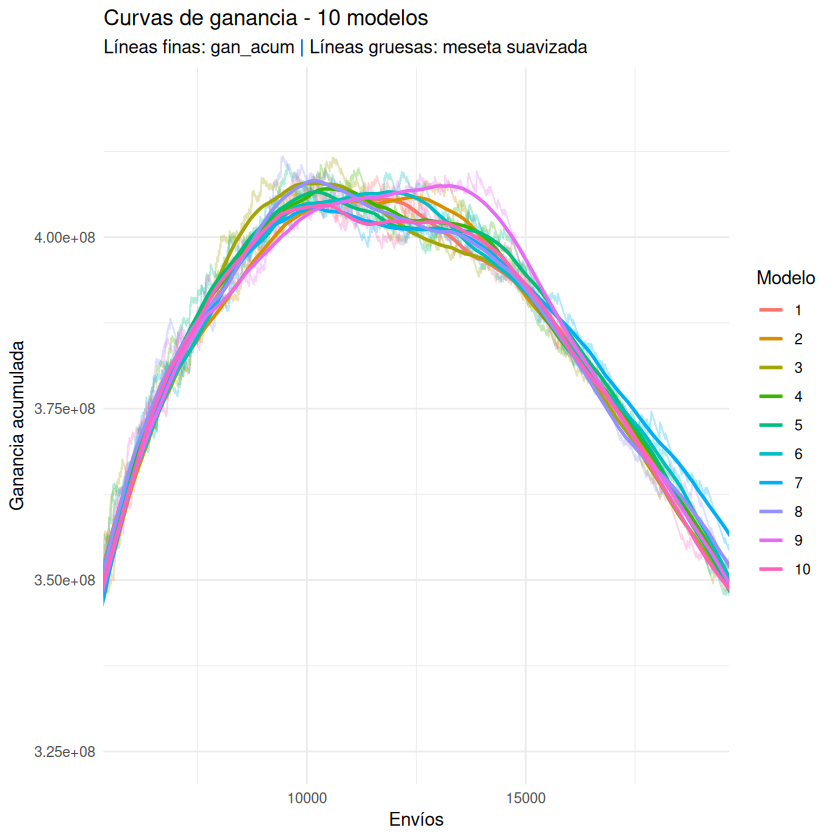

In [34]:
library(data.table)
library(ggplot2)

# Preparar data.table para acumular todas las curvas
tb_todas <- data.table()

cat("Calculando curvas para", length(PARAM$prod$semillas), "modelos...\n")

for(i in seq_along(PARAM$prod$semillas)) {
  sem <- PARAM$prod$semillas[i]
  
  cat("Modelo", i, "de", length(PARAM$prod$semillas), "\r")
  
  # Cargar modelo y predecir
  modelo <- lgb.load(paste0("modelitos_prod/mod_", sem, ".txt"))
  vpred <- predict(modelo, mfuture_prod)
  
  # Crear tabla
  tb <- data.table(gan = dfuture_prod$gan, prob = vpred)
  setorder(tb, -prob)
  tb[, gan_acum := cumsum(gan)]
  
  # Meseta suavizada
  tb[, gan_meseta := frollmean(
    x = gan_acum,
    n = 2001,
    align = "center",
    na.rm = TRUE
  )]
  
  # Agregar identificador de modelo
  tb[, `:=`(
    envio = .I,
    modelo = i,
    semilla = sem
  )]
  
  # Acumular
  tb_todas <- rbind(tb_todas, tb[, .(envio, gan_acum, gan_meseta, modelo, semilla)])
  
  rm(modelo, vpred, tb)
  gc()
}

cat("\n✅ Curvas calculadas\n")

# Gráfico con todas las curvas
ggplot(tb_todas) +
  geom_line(aes(envio, gan_acum, group = modelo, color = as.factor(modelo)), 
            alpha = 0.3) +
  geom_line(aes(envio, gan_meseta, group = modelo, color = as.factor(modelo)), 
            linewidth = 1) +
  coord_cartesian(xlim = c(6000, 19000), ylim = c(325000000, 420000000)) +
  labs(
    title = paste("Curvas de ganancia -", length(PARAM$prod$semillas), "modelos"),
    subtitle = "Líneas finas: gan_acum | Líneas gruesas: meseta suavizada",
    x = "Envíos",
    y = "Ganancia acumulada",
    color = "Modelo"
  ) +
  theme_minimal() +
  theme(legend.position = "right")

In [ ]:
archivos <- list.files("./modelitos_prod/", pattern = "mod_.*\\.txt", full.names = TRUE)

modelos_cargados <- lapply(archivos, function(a) {
  lgb.load(a)
})

### Prediccion

In [35]:
if(file.exists("prediccion_prod.txt"))
  file.remove("prediccion_prod.txt")

vpred_acum <- rep(0.0, nrow(dfuture_prod))
qacumulados <- 0

cat("Prediciendo con ensamble de modelos...\n")

for(sem in PARAM$prod$semillas) {
  arch_modelo <- paste0("./modelitos_prod/mod_", sem, ".txt")
  
  if(file.exists(arch_modelo)) {
    modelo_final <- lgb.load(arch_modelo)
    vpred_acum <- vpred_acum + predict(modelo_final, mfuture_prod)
    qacumulados <- qacumulados + 1
    rm(modelo_final)
    gc()
  }
}

vpred_acum <- vpred_acum / qacumulados

Prediciendo con ensamble de modelos...


In [36]:
tb_prediccion <- dfuture_prod[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := vpred_acum]
setorder(tb_prediccion, -prob)

# Agregar ranking
tb_prediccion[, ranking := .I]

# Estadísticas
cat("\n=== ESTADÍSTICAS DE PREDICCIÓN ===\n")
cat("Total clientes:", nrow(tb_prediccion), "\n")
cat("Probabilidad mínima:", min(tb_prediccion$prob), "\n")
cat("Probabilidad máxima:", max(tb_prediccion$prob), "\n")
cat("Probabilidad promedio:", mean(tb_prediccion$prob), "\n")
cat("Probabilidad mediana:", median(tb_prediccion$prob), "\n")


=== ESTADÍSTICAS DE PREDICCIÓN ===
Total clientes: 164313 
Probabilidad mínima: 2.619881e-06 
Probabilidad máxima: 0.9990369 
Probabilidad promedio: 0.05309575 
Probabilidad mediana: 0.001165312 


In [37]:
# genero archivos con los  "envios" mejores
dir.create("kaggle", showWarnings=FALSE)

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

envios <- 11000
tb_prediccion[, Predicted := 0L] # seteo inicial a 0
tb_prediccion[1:envios, Predicted := 1L] # marco los primeros

archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", envios, ".csv")

# grabo el archivo
fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
  file= archivo_kaggle,
  sep= ","
)

### Submission